# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NB_Path = pathlib.Path.cwd()
        RepoPath = NB_Path.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        monkey_defs = params.monkey_defs
        defs = monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
        
        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NB_Path)
    
    
    %run "S4-decode-example.ipynb"
    
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


---
# Part 1

functions that plot each panel.



In [9]:
def get_ex_data():
    warnings.filterwarnings("ignore")
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    warnings.filterwarnings("default")
    return raster_example_df

---
All in One

In [10]:
def _decode_score_and_traj(pairDF):    
    AllData, AllVel = defs.get_data_array_and_vel(pairDF, defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    n_target,n_trial,n_time,n_comp = AllData1.shape

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    Y_train_x,Y_train_y = AllVel1.T
    Y_test_x,Y_test_y = AllVel2.T
    reg_x, reg_y = LinearRegression(), LinearRegression()
    orig_data = (AllVel1.reshape(n_target, n_trial, n_time, 2),AllVel2.reshape(n_target, n_trial, n_time, 2))
    
    #aligned
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    a_scores = (x_score,y_score)
    a_data = (reg_x.predict(V).reshape(n_target, n_trial, n_time),reg_y.predict(V).reshape(n_target, n_trial, n_time))
    
    #unaligned
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
    u_scores = (x_score,y_score)
    u_data = (reg_x.predict(X2).reshape(n_target, n_trial, n_time),reg_y.predict(X2).reshape(n_target, n_trial, n_time))
    
    #Within
    n_trials = int(AllData.shape[-3] /2)
    AllData1 = AllData[0,...][:,:n_trials, :,:]
    AllData2 = AllData[0,...][:,-n_trials:,:,:]
    AllVel1 = AllVel[0,...][:,:n_trials, :,:]
    AllVel2 = AllVel[0,...][:,-n_trials:,:,:]
    _,ntrial,ntime,ncomp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    # resizing
    X1 = AllData1.reshape((-1,ncomp))
    X2 = AllData2.reshape((-1,ncomp))
    # controlling the size
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    Y_train_x,Y_train_y = AllVel1.T
    Y_test_x,Y_test_y = AllVel2.T

    x_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=5).mean()
    y_score=cross_val_score(LinearRegression(),np.vstack((X1,X2)),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=5).mean()

    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    w_scores = (x_score,y_score)
    w_data = (reg_x.predict(X2).reshape(n_target, ntrial, ntime),reg_y.predict(X2).reshape(n_target, ntrial, ntime))


    return n_target, n_trial, n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores

---
plot

In [57]:
def plot_decoding_ex(fig, gs):

    allDFs = get_ex_data()
    n_target, n_trial, n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores = _decode_score_and_traj (allDFs)
    trial_n = 0

    
    axes = []
    for i in range(defs.n_targets):
        axx = fig.add_subplot(gs[0,i])
        axy = fig.add_subplot(gs[1,i])
        axes.append((axx, axy))
        utility.phantom_axes(axx)
        utility.phantom_axes(axy)

        axx.plot(orig_data[1][i,trial_n,:,0], color='k', label='Actual')
        axy.plot(orig_data[1][i,trial_n,:,1], color='k', label='Actual')

        axx.plot(w_data[0][i,trial_n,:], color='b', label=fr'Within ($R^2={sum(w_scores)/2:0.2f}$)')
        axy.plot(w_data[1][i,trial_n,:], color='b', label='Within')

        axx.plot(a_data[0][i,trial_n,:], color='r', label=fr'Aligned ($R^2={sum(a_scores)/2:0.2f}$)')
        axy.plot(a_data[1][i,trial_n,:], color='r', label='Aligned')

        axx.plot(u_data[0][i,trial_n,:], color='g', label=fr'Unaligned ($R^2={sum(u_scores)/2:0.2f}$)')
        axy.plot(u_data[1][i,trial_n,:], color='g', label='Unaligned')

        axx.set_title(f'Target {i+1}')

    axx.legend(ncol=4, loc='center',bbox_to_anchor=(.5,.5), bbox_transform=fig.transFigure)
    
    return np.array(axes).T

# Part 2

Plot figure

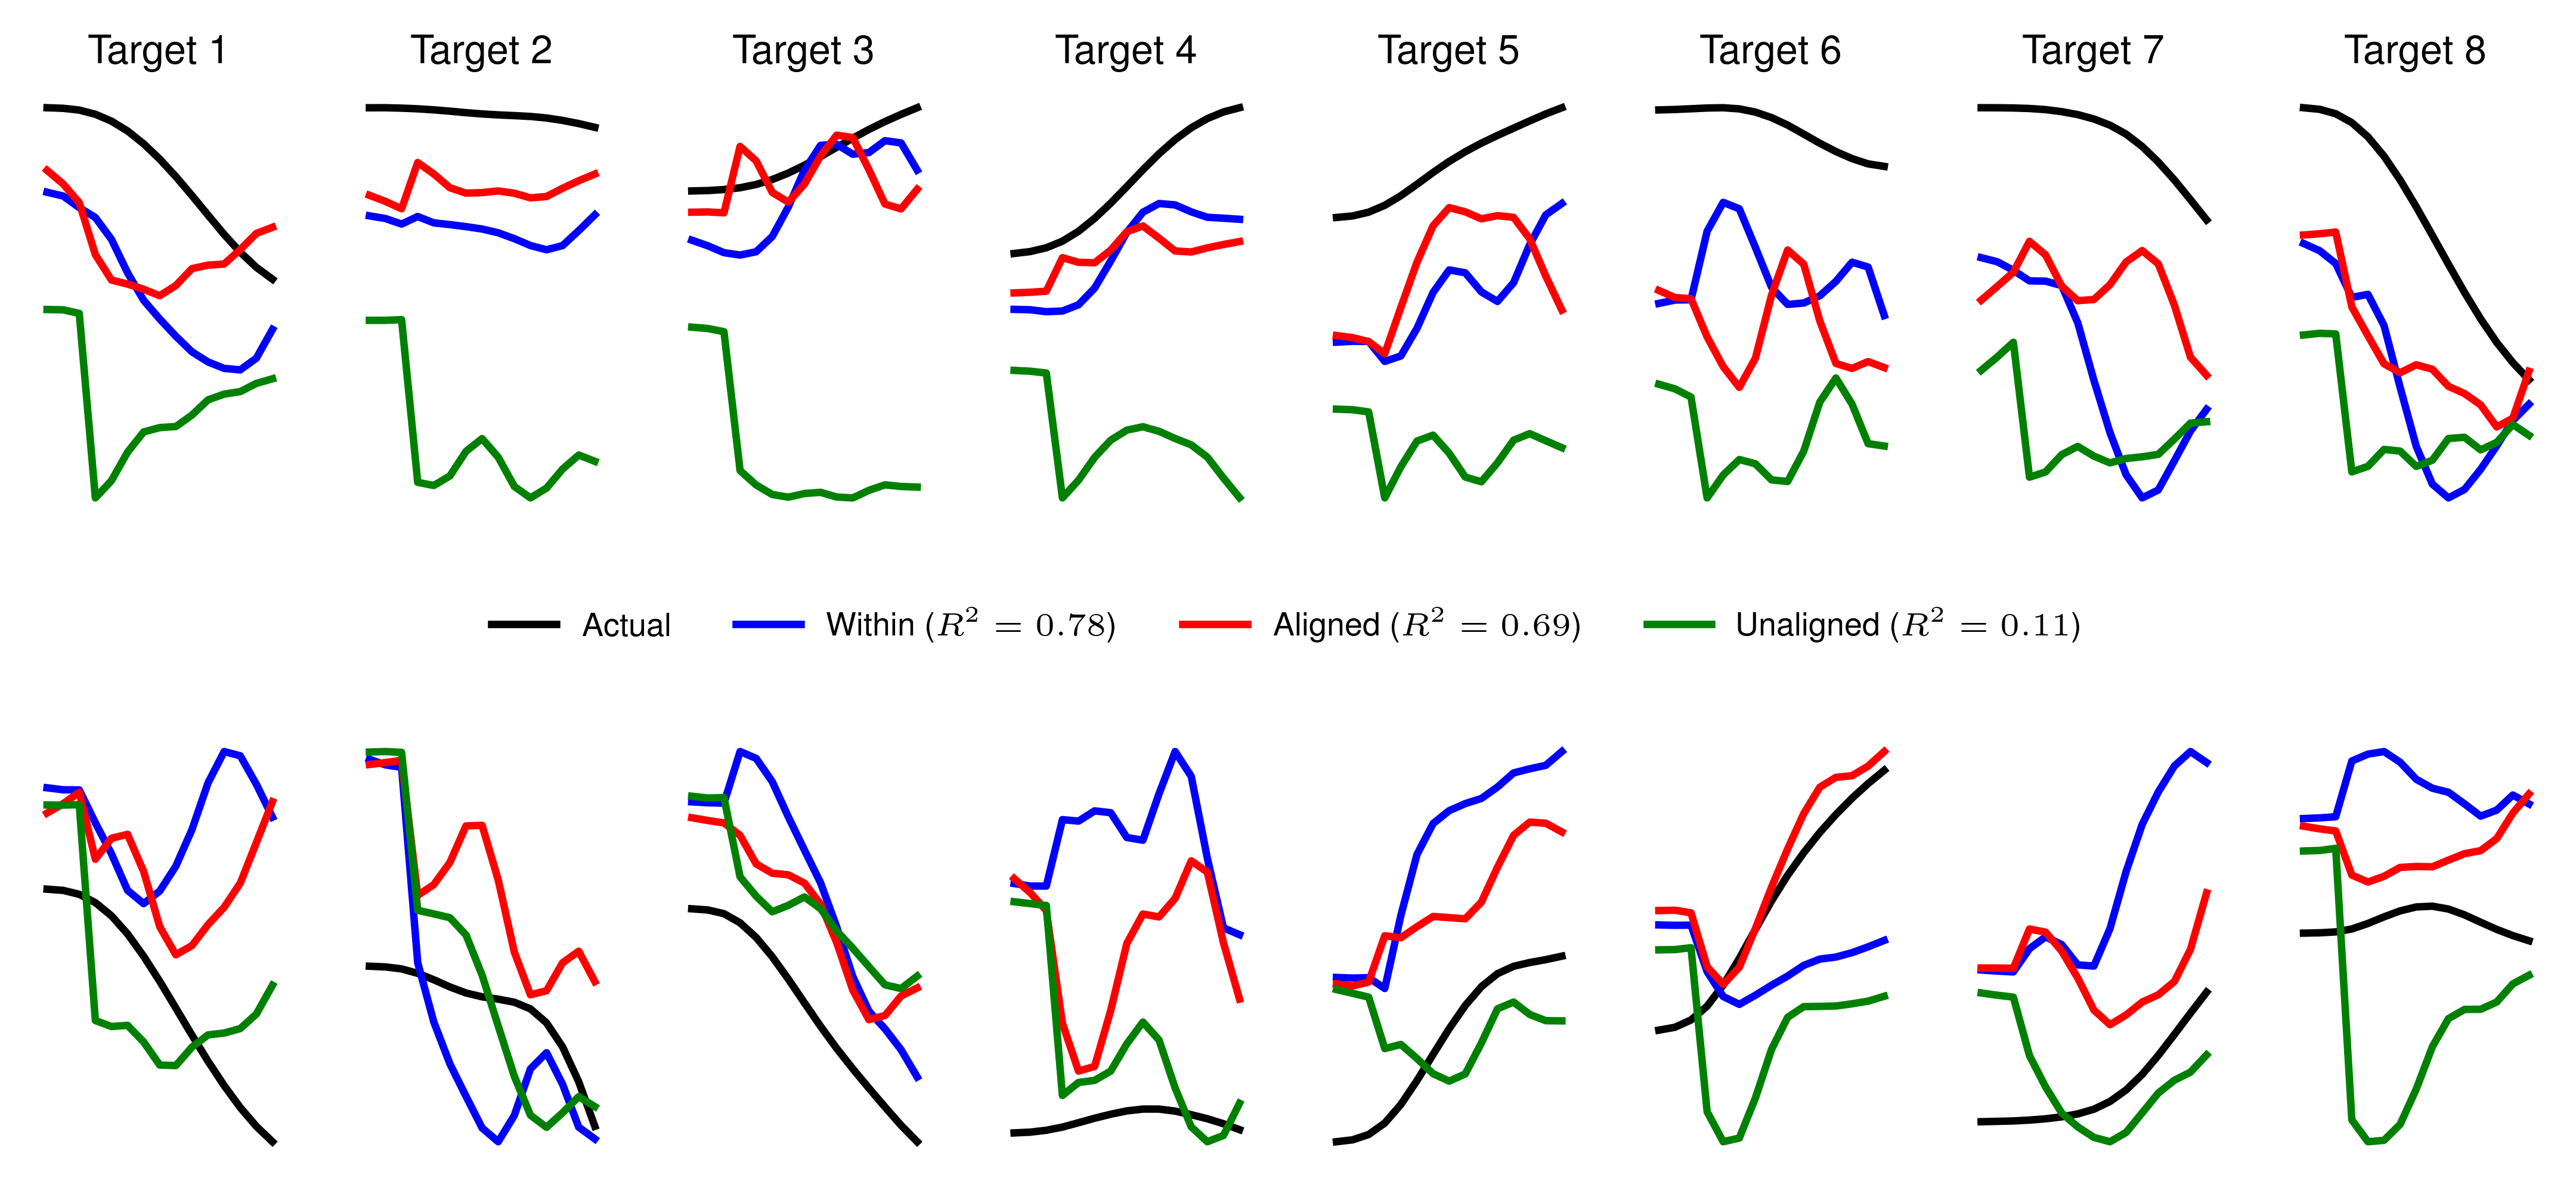

In [59]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= (params.LargeFig[0],params.panels.BigH)
    fig=plt.figure(figsize=figsize)
    
   
    
    ##########################################
    # 1: Decoding 
    gs1   =fig.add_gridspec(nrows=2, ncols=defs.n_targets,
                           left=0,  # .7" offset
                           right=1,
                           bottom=0,
                           top=1,
                           wspace=0.3, hspace = .5)

       
    axes1 = plot_decoding_ex(fig, gs1)
    axes1[0,0].set_ylabel('$X$')
    axes1[1,0].set_ylabel('$Y$')

    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
#     OFFX=np.array([.02]*len(AXES))
#     OFFY=np.array([.03]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
#     params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS4-decode-example.pdf', format='pdf', bbox_inches='tight')